In [12]:
%matplotlib inline
import numpy as np
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt

rand = np.random.rand

class Bandits(object):
    """
    This class represents N bandits machines.

    parameters:
        p_array: a (n,) Numpy array of probabilities >0, <1.

    methods:
        pull( i ): return the results, 0 or 1, of pulling 
                   the ith bandit.
    """
    def __init__(self, p_array):
        self.p = p_array
        self.optimal = np.argmax(p_array)
        
    def pull(self, i):
        #i is which arm to pull
        return np.random.rand() < self.p[i]
    
    def __len__(self):
        return len(self.p)

    
class BayesianStrategy(object):
    """
    Implements a online, learning strategy to solve
    the Multi-Armed Bandit problem.
    
    parameters:
        bandits: a Bandit class with .pull method
    
    methods:
        sample_bandits(n): sample and train on n pulls.

    attributes:
        N: the cumulative number of samples
        choices: the historical choices as a (N,) array
        bb_score: the historical score as a (N,) array
    """
    
    def __init__(self, bandits):
        
        self.bandits = bandits
        n_bandits = len(self.bandits)
        self.wins = np.zeros(n_bandits)
        self.trials = np.zeros(n_bandits)
        self.N = 0
        self.choices = []
        self.bb_score = []

    
    def sample_bandits(self, n=1):
        
        bb_score = np.zeros(n)
        choices = np.zeros(n)
        
        for k in range(n):
            #sample from the bandits's priors, and select the largest sample
            choice = np.argmax(np.random.beta(1 + self.wins, 1 + self.trials - self.wins))
            
            #sample the chosen bandit
            result = self.bandits.pull(choice)
            
            #update priors and score
            self.wins[choice] += result
            self.trials[choice] += 1
            bb_score[k] = result 
            self.N += 1
            choices[k] = choice
            
        self.bb_score = np.r_[self.bb_score, bb_score]
        self.choices = np.r_[self.choices, choices]
        return

In [3]:
figsize(11.0, 10)

beta = stats.beta
x = np.linspace(0.001,.999,200)

def plot_priors(bayesian_strategy, prob, lw = 3, alpha = 0.2, plt_vlines = True):
    ## plotting function
    wins = bayesian_strategy.wins
    trials = bayesian_strategy.trials
    for i in range(prob.shape[0]):
        y = beta(1+wins[i], 1 + trials[i] - wins[i])
        p = plt.plot(x, y.pdf(x), lw = lw)
        c = p[0].get_markeredgecolor()
        plt.fill_between(x,y.pdf(x),0, color = c, alpha = alpha, 
                         label="underlying probability: %.2f" % prob[i])
        if plt_vlines:
            plt.vlines(prob[i], 0, y.pdf(prob[i]) ,
                       colors = c, linestyles = "--", lw = 2)
        plt.autoscale(tight = "True")
        plt.title("Posteriors After %d pull" % bayesian_strategy.N +\
                    "s"*(bayesian_strategy.N > 1))
        plt.autoscale(tight=True)
    return

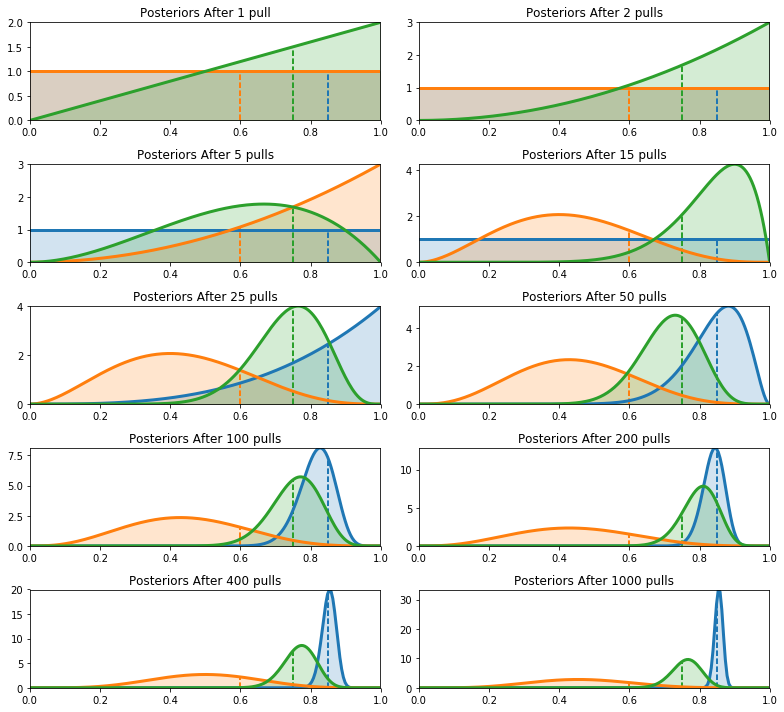

In [4]:
hidden_prob = np.array([0.85, 0.60, 0.75])
bandits = Bandits(hidden_prob)
bayesian_strat = BayesianStrategy(bandits)

draw_samples = [1, 1, 3, 10, 10, 25, 50, 100, 200, 600]

for j,i in enumerate(draw_samples):
    plt.subplot(5, 2, j+1) 
    bayesian_strat.sample_bandits(i)
    plot_priors(bayesian_strat, hidden_prob)
    #plt.legend()
    plt.autoscale(tight = True)
plt.tight_layout()

In [6]:
from urllib.request import urlretrieve
urlretrieve('https://git.io/vXL9A','other_strats.py')

('other_strats.py', <http.client.HTTPMessage at 0x10fdaae48>)

In [7]:
figsize(12.5, 5)
from other_strats import *

#define a harder problem
hidden_prob = np.array([0.15, 0.2, 0.1, 0.05])
bandits = Bandits(hidden_prob)

#define regret
def regret(probabilities, choices):
    w_opt = probabilities.max()
    return (w_opt - probabilities[choices.astype(int)]).cumsum()

#create new strategies
strategies= [upper_credible_choice, 
            bayesian_bandit_choice, 
            ucb_bayes , 
            max_mean,
            random_choice]
algos = []
for strat in strategies:
    algos.append(GeneralBanditStrat(bandits, strat))

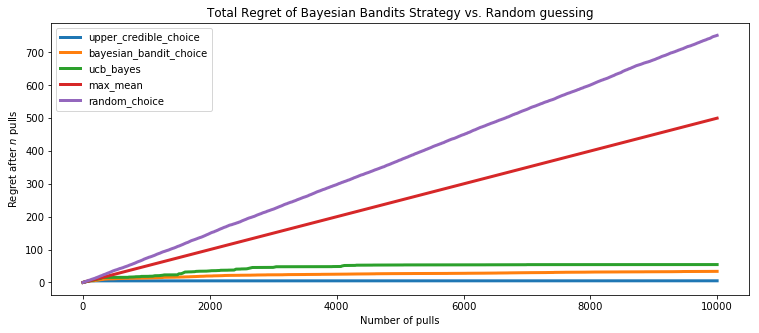

In [8]:
#train 10000 times
for strat in algos:
    strat.sample_bandits(10000)
    
#test and plot
for i,strat in enumerate(algos):
    _regret = regret(hidden_prob, strat.choices)
    plt.plot(_regret, label = strategies[i].__name__, lw = 3)

plt.title("Total Regret of Bayesian Bandits Strategy vs. Random guessing")
plt.xlabel("Number of pulls")
plt.ylabel("Regret after $n$ pulls");
plt.legend(loc = "upper left");

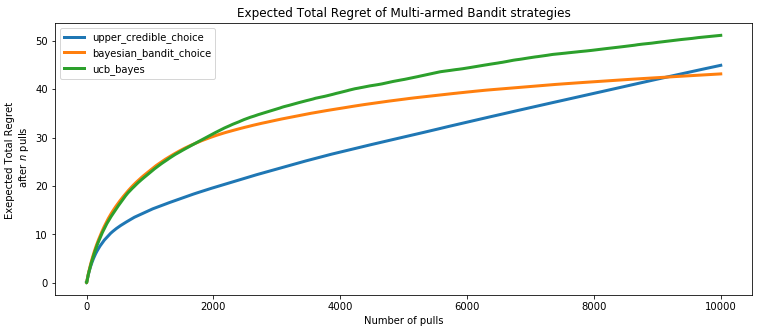

In [9]:
#this can be slow, so I recommend NOT running it. 

trials = 500
expected_total_regret = np.zeros((10000, 3))

for i_strat, strat in enumerate(strategies[:-2]):
    for i in range(trials):
        general_strat = GeneralBanditStrat(bandits, strat)
        general_strat.sample_bandits(10000)
        _regret =  regret(hidden_prob, general_strat.choices)
        expected_total_regret[:,i_strat] += _regret
    plt.plot(expected_total_regret[:,i_strat]/trials, lw =3, label = strat.__name__)
        
plt.title("Expected Total Regret of Multi-armed Bandit strategies")
plt.xlabel("Number of pulls")
plt.ylabel("Exepected Total Regret \n after $n$ pulls");
plt.legend(loc = "upper left");

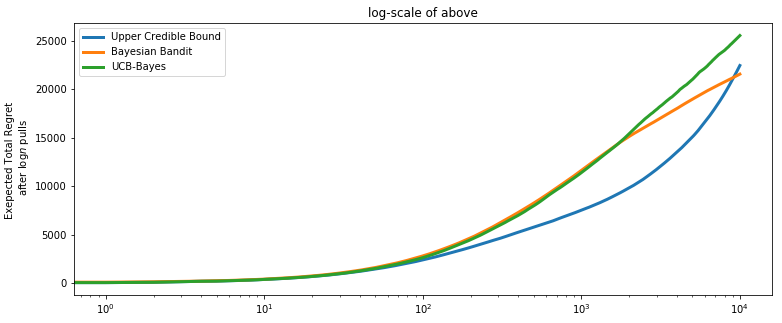

In [10]:
plt.figure()
[pl1, pl2, pl3] = plt.plot(expected_total_regret[:, [0,1,2]], lw = 3)
plt.xscale("log")
plt.legend([pl1, pl2, pl3], 
           ["Upper Credible Bound", "Bayesian Bandit", "UCB-Bayes"],
            loc="upper left")
plt.ylabel("Exepected Total Regret \n after $\log{n}$ pulls");
plt.title( "log-scale of above" );
plt.ylabel("Exepected Total Regret \n after $\log{n}$ pulls");

[ 0.0200429   0.01045959  0.10309636  0.19096461  0.02177713  0.27260462
  0.10076849  0.05288601  0.00866698  0.2237965   0.02244815  0.05700055
  0.06983741  0.00931798  0.04774951  0.09415901  0.10405666  0.1761212
  0.02221377  0.06027817  0.14065823  0.02095995  0.07314638  0.21631849
  0.04205145  0.28648804  0.08017105  0.04781502  0.00113949  0.01705348
  0.16564369  0.02682064  0.10831459  0.03761561  0.06963732]


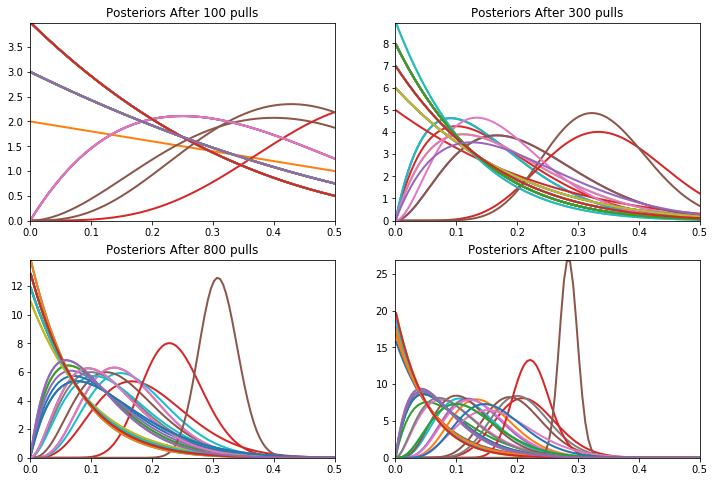

In [11]:
figsize(12.0, 8)
beta = stats.beta
hidden_prob = beta.rvs(1,13, size = 35)
print(hidden_prob)
bandits = Bandits(hidden_prob)
bayesian_strat = BayesianStrategy(bandits)

for j,i in enumerate([100, 200, 500, 1300]):
    plt.subplot(2, 2, j+1) 
    bayesian_strat.sample_bandits(i)
    plot_priors(bayesian_strat, hidden_prob, lw = 2, alpha = 0.0, plt_vlines=False)
    #plt.legend()
    plt.xlim(0, 0.5)